In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

Cloning into 'ERA_V1'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 447 (delta 128), reused 137 (delta 68), pack-reused 237
Receiving objects: 100% (447/447), 6.05 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (246/246), done.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_8")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from s8_utils import load_cifar10_data, preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from s8_model import Model_Net, model_summary, model_train, model_test

Allocate GPU

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cifar_10_model = Model_Net(norm_type = 'batch_norm', num_groups = 2).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1

Define Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation((-10., 10.),fill=(0.,0.,0.)),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])

Download Data

In [6]:
train_data, test_data, class_names = load_cifar10_data(train_transforms, test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 13433964.63it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Define train and test loaders

In [7]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, **kwargs)

Calculate Mean and Std of dataset

In [ ]:
from tqdm import tqdm
import numpy as np
mean_r = 0
mean_g = 0
mean_b = 0

std_r = 0
std_g = 0
std_b = 0
loader_for_stats = test_loader
for img,_ in tqdm(loader_for_stats):
    img = np.asarray(img)
    # calculate Mean of Normalized dataset
    mean_r += np.mean(img[:,0,:,:])
    mean_g += np.mean(img[:,1,:,:])
    mean_b += np.mean(img[:,2,:,:])
    # calculate std of Normalized dataset
    std_r += np.var(img[:,0,:,:])
    std_g += np.var(img[:,1,:,:])
    std_b += np.var(img[:,2,:,:])
mean_r = mean_r / len(loader_for_stats)
mean_g = mean_g / len(loader_for_stats)
mean_b = mean_b / len(loader_for_stats)
std_r = np.sqrt(((1./(len(loader_for_stats)-1))*std_r))
std_g = np.sqrt(((1./(len(loader_for_stats)-1))*std_g))
std_b = np.sqrt(((1./(len(loader_for_stats)-1))*std_b))
print(f"dataset mean: {mean_r:0.3f}, {mean_g:0.3f}, {mean_b:0.3f}")
print(f"dataset std: {std_r:0.3f}, {std_g:0.3f}, {std_b:0.3f}")


Show sample Images

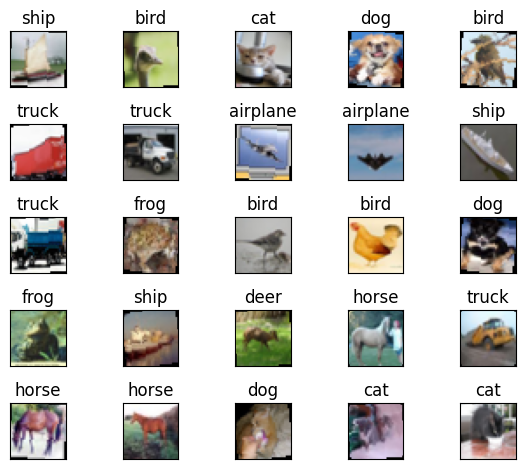

In [8]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Define plotting functions

In [24]:
import matplotlib.pyplot as plt
import numpy as np
def show_incorrect_predictions(incorrect_predictions, class_names, num_rows = 5, num_cols = 5):
    cnt = 0
    num_images_to_preview = num_rows*num_cols
    fig = plt.figure()
    for this_pred in incorrect_predictions:
        orig_img = this_pred[0]
        inv_transforms = transforms.Compose([transforms.Normalize((0.,0.,0.,),
                                            (1./0.247,1./0.244,1./0.262)),
                                        transforms.Normalize((-0.491,-0.482,-0.447),
                                                             (1.0,1.0,1.0))])
        target_label = this_pred[1]
        predicted_label = this_pred[2]
        output_label = this_pred[3]
        un_normalized_tensor_img = inv_transforms(orig_img.squeeze())
        un_normalized_numpy_img = np.asarray(un_normalized_tensor_img)
        ax = fig.add_subplot(num_rows, num_cols, cnt+1,xticks=[],yticks=[])
        plt.subplot(num_rows,num_cols,cnt+1)
        plt.imshow(un_normalized_numpy_img.transpose((1,2,0)))
        title_str = f"{class_names[str(target_label.item())]}/{class_names[str(predicted_label.item())]}"
        #title_str = f"{str(target_label.item())}/{str(predicted_label.item())}"
        ax.set_title(title_str,fontsize=8)
        cnt+=1
        if cnt == num_images_to_preview:
            break
    #plt.tight_layout()
    plt.show()


def plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc = 99):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].axhline(target_test_acc, color='r')
    axs[1, 1].set_title("Test Accuracy")

Train model using Batch Normalization

In [10]:
model_bn = Model_Net(norm_type='batch_norm').to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    scheduler.step()
target_test_acc = 70.


Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 1


loss=1.2695724964141846 batch_id=390 Accuracy = 43.29: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]



Test set: Average loss: 1.4205, Accuracy: 4808/10000 (48.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 2


loss=0.9005096554756165 batch_id=390 Accuracy = 58.77: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s]



Test set: Average loss: 1.1154, Accuracy: 5980/10000 (59.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 3


loss=1.019941806793213 batch_id=390 Accuracy = 64.18: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]



Test set: Average loss: 0.9772, Accuracy: 6517/10000 (65.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 4


loss=1.0187866687774658 batch_id=390 Accuracy = 68.05: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]



Test set: Average loss: 0.8790, Accuracy: 6944/10000 (69.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 5


loss=0.9536792039871216 batch_id=390 Accuracy = 70.34: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]



Test set: Average loss: 0.8322, Accuracy: 7096/10000 (70.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 6


loss=1.0389286279678345 batch_id=390 Accuracy = 72.15: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]



Test set: Average loss: 0.8068, Accuracy: 7178/10000 (71.78%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 7


loss=0.686888575553894 batch_id=390 Accuracy = 73.44: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.7611, Accuracy: 7333/10000 (73.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 8


loss=0.5948616862297058 batch_id=390 Accuracy = 74.67: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 0.7618, Accuracy: 7394/10000 (73.94%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 9


loss=0.6360434293746948 batch_id=390 Accuracy = 77.46: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]



Test set: Average loss: 0.6198, Accuracy: 7830/10000 (78.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 10


loss=0.6322006583213806 batch_id=390 Accuracy = 78.04: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s]



Test set: Average loss: 0.6090, Accuracy: 7871/10000 (78.71%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 11


loss=0.6012459397315979 batch_id=390 Accuracy = 78.29: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]



Test set: Average loss: 0.6071, Accuracy: 7905/10000 (79.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 12


loss=0.5022391080856323 batch_id=390 Accuracy = 78.55: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]



Test set: Average loss: 0.6074, Accuracy: 7882/10000 (78.82%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 13


loss=0.7018263936042786 batch_id=390 Accuracy = 79.02: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]



Test set: Average loss: 0.6009, Accuracy: 7908/10000 (79.08%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 14


loss=0.541342556476593 batch_id=390 Accuracy = 78.76: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]



Test set: Average loss: 0.5980, Accuracy: 7949/10000 (79.49%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 15


loss=0.7323439121246338 batch_id=390 Accuracy = 78.99: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]



Test set: Average loss: 0.6031, Accuracy: 7920/10000 (79.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 16


loss=0.7040764093399048 batch_id=390 Accuracy = 79.04: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]



Test set: Average loss: 0.5937, Accuracy: 7919/10000 (79.19%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 17


loss=0.7084693908691406 batch_id=390 Accuracy = 79.47: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 0.5931, Accuracy: 7924/10000 (79.24%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 18


loss=0.6955525279045105 batch_id=390 Accuracy = 79.57: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s]



Test set: Average loss: 0.5869, Accuracy: 7949/10000 (79.49%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 19


loss=0.663116455078125 batch_id=390 Accuracy = 79.54: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]



Test set: Average loss: 0.5903, Accuracy: 7937/10000 (79.37%)

Adjusting learning rate of group 0 to 1.0000e-04.


Plot results for Batch Norm experiment

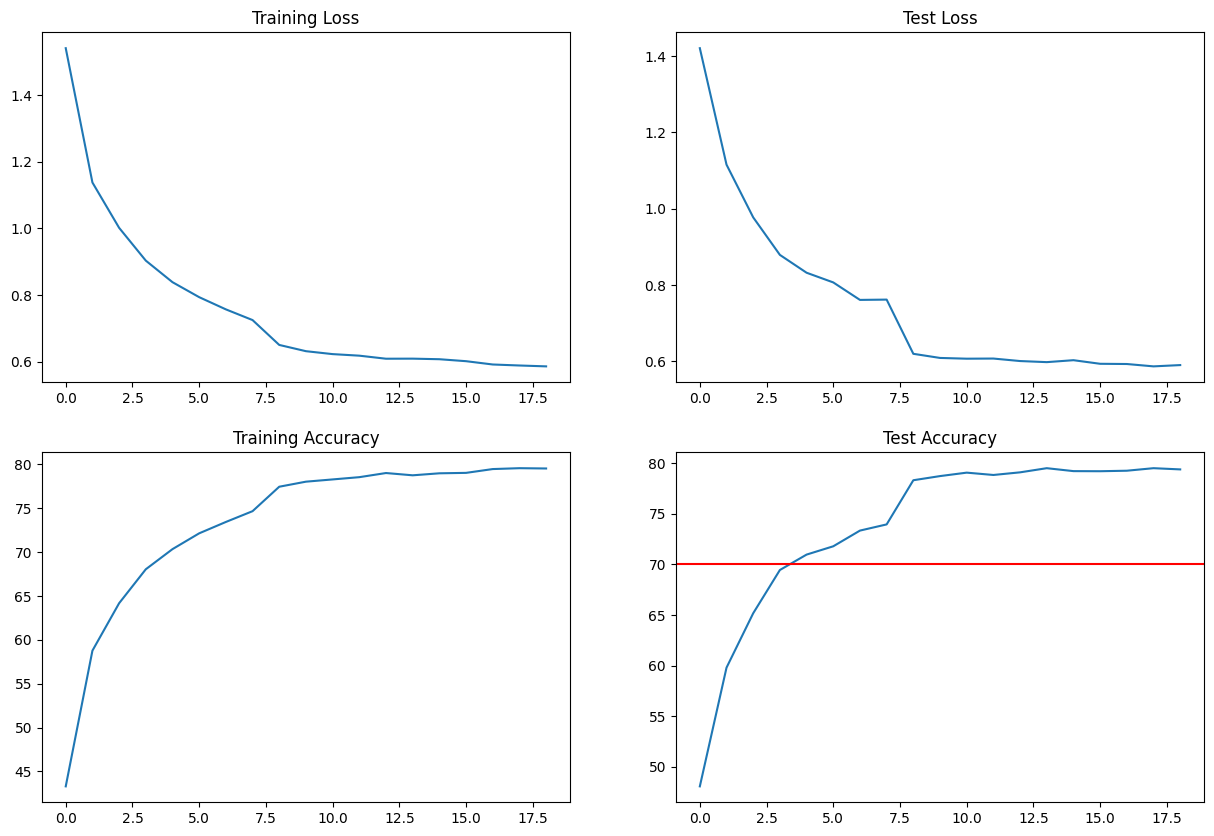

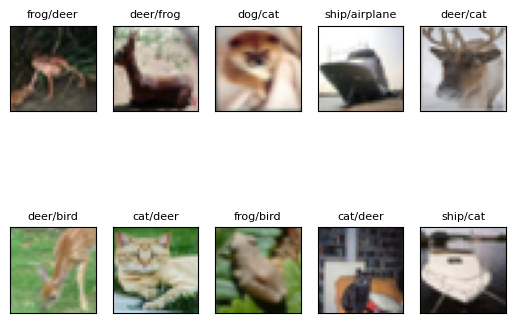

In [26]:
plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Train Model using Layer Normalization

In [27]:
model_ln = Model_Net(norm_type='layer_norm').to(device)
optimizer_ln = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
scheduler_ln = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ln, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
train_losses_ln = []
test_losses_ln = []
train_acc_ln = []
test_acc_ln = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_ln, device, train_loader, optimizer_ln, train_acc_ln, train_losses_ln)
    this_loss = model_test(model_ln, device, test_loader, test_acc_ln, test_losses_ln)
    scheduler_ln.step(this_loss)
target_test_acc = 70.



epoch: 1


loss=1.7379287481307983 batch_id=390 Accuracy = 29.30: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]



Test set: Average loss: 1.6984, Accuracy: 3720/10000 (37.20%)

epoch: 2


loss=1.4877793788909912 batch_id=390 Accuracy = 42.01: 100%|██████████| 391/391 [00:43<00:00,  9.08it/s]



Test set: Average loss: 1.4523, Accuracy: 4654/10000 (46.54%)

epoch: 3


loss=1.222610354423523 batch_id=390 Accuracy = 48.63: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]



Test set: Average loss: 1.3049, Accuracy: 5218/10000 (52.18%)

epoch: 4


loss=1.2974692583084106 batch_id=390 Accuracy = 53.66: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]



Test set: Average loss: 1.1807, Accuracy: 5730/10000 (57.30%)

epoch: 5


loss=1.0676300525665283 batch_id=390 Accuracy = 57.46: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]



Test set: Average loss: 1.1147, Accuracy: 6059/10000 (60.59%)

epoch: 6


loss=1.0566489696502686 batch_id=390 Accuracy = 60.54: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s]



Test set: Average loss: 1.0432, Accuracy: 6194/10000 (61.94%)

epoch: 7


loss=1.160590648651123 batch_id=390 Accuracy = 62.69: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 0.9828, Accuracy: 6492/10000 (64.92%)

epoch: 8


loss=1.2375764846801758 batch_id=390 Accuracy = 64.97: 100%|██████████| 391/391 [00:40<00:00,  9.54it/s]



Test set: Average loss: 0.9431, Accuracy: 6720/10000 (67.20%)

epoch: 9


loss=0.9349738955497742 batch_id=390 Accuracy = 66.89: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]



Test set: Average loss: 0.8783, Accuracy: 6944/10000 (69.44%)

epoch: 10


loss=1.027403473854065 batch_id=390 Accuracy = 68.15: 100%|██████████| 391/391 [00:41<00:00,  9.52it/s]



Test set: Average loss: 0.8416, Accuracy: 7027/10000 (70.27%)

epoch: 11


loss=0.886254608631134 batch_id=390 Accuracy = 69.19: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]



Test set: Average loss: 0.8574, Accuracy: 7032/10000 (70.32%)

epoch: 12


loss=0.8492103815078735 batch_id=390 Accuracy = 70.25: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]



Test set: Average loss: 0.8006, Accuracy: 7204/10000 (72.04%)

epoch: 13


loss=0.8771411180496216 batch_id=390 Accuracy = 71.32: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]



Test set: Average loss: 0.7912, Accuracy: 7235/10000 (72.35%)

epoch: 14


loss=0.8176702260971069 batch_id=390 Accuracy = 71.83: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s]



Test set: Average loss: 0.8103, Accuracy: 7145/10000 (71.45%)

epoch: 15


loss=0.9453116655349731 batch_id=390 Accuracy = 72.45: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]



Test set: Average loss: 0.7982, Accuracy: 7230/10000 (72.30%)

epoch: 16


loss=0.8763958811759949 batch_id=390 Accuracy = 73.17: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]



Test set: Average loss: 0.7303, Accuracy: 7481/10000 (74.81%)

epoch: 17


loss=0.628739058971405 batch_id=390 Accuracy = 73.74: 100%|██████████| 391/391 [00:42<00:00,  9.31it/s]



Test set: Average loss: 0.7626, Accuracy: 7373/10000 (73.73%)

epoch: 18


loss=0.8284576535224915 batch_id=390 Accuracy = 74.46: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]



Test set: Average loss: 0.7012, Accuracy: 7544/10000 (75.44%)

epoch: 19


loss=0.6976156830787659 batch_id=390 Accuracy = 74.69: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 0.7019, Accuracy: 7587/10000 (75.87%)



Show Results for Layer Norm experiments

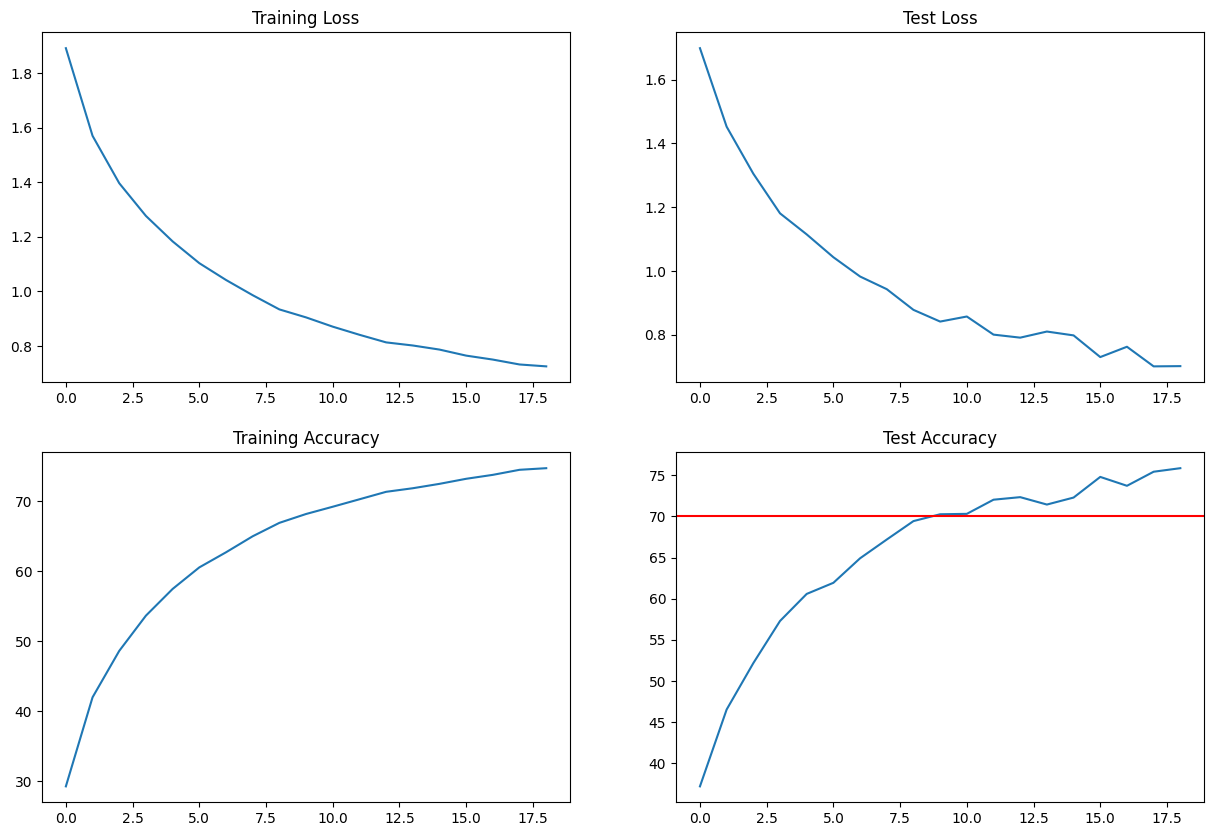

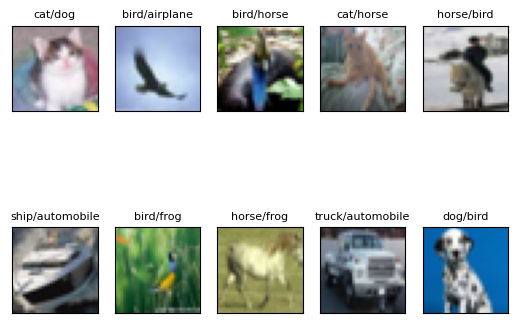

In [28]:
plot_statistics(train_losses_ln, train_acc_ln, test_losses_ln, test_acc_ln, target_test_acc)
incorrect_predictions_ln = get_incorrect_predictions(model_ln, test_loader, device)
show_incorrect_predictions(incorrect_predictions_ln, class_names, num_rows = 2, num_cols = 5)

Train Model using Group Normalization

In [29]:
model_gn = Model_Net(norm_type='group_norm', num_groups=2).to(device)
optimizer_gn = optim.SGD(model_gn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer_gn, step_size=8, gamma=0.1, verbose=True)
train_losses_gn = []
test_losses_gn = []
train_acc_gn = []
test_acc_gn = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_gn, device, train_loader, optimizer_gn, train_acc_gn, train_losses_gn)
    this_loss = model_test(model_gn, device, test_loader, test_acc_gn, test_losses_gn)
    scheduler.step()
target_test_acc = 70.



Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 1


loss=1.6987419128417969 batch_id=390 Accuracy = 28.37: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 1.6411, Accuracy: 3941/10000 (39.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 2


loss=1.3748972415924072 batch_id=390 Accuracy = 41.72: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 1.4668, Accuracy: 4624/10000 (46.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 3


loss=1.259343147277832 batch_id=390 Accuracy = 48.12: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s]



Test set: Average loss: 1.3394, Accuracy: 5110/10000 (51.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 4


loss=1.1183831691741943 batch_id=390 Accuracy = 52.96: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]



Test set: Average loss: 1.3303, Accuracy: 5245/10000 (52.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 5


loss=0.7806912660598755 batch_id=390 Accuracy = 56.41: 100%|██████████| 391/391 [00:42<00:00,  9.11it/s]



Test set: Average loss: 1.1458, Accuracy: 5975/10000 (59.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 6


loss=1.1137795448303223 batch_id=390 Accuracy = 59.07: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 1.0723, Accuracy: 6186/10000 (61.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 7


loss=1.009968638420105 batch_id=390 Accuracy = 61.16: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s]



Test set: Average loss: 1.0547, Accuracy: 6264/10000 (62.64%)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 8


loss=1.049285888671875 batch_id=390 Accuracy = 63.87: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]



Test set: Average loss: 0.9843, Accuracy: 6529/10000 (65.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 9


loss=0.7400364279747009 batch_id=390 Accuracy = 68.39: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s]



Test set: Average loss: 0.8704, Accuracy: 6926/10000 (69.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 10


loss=1.0306764841079712 batch_id=390 Accuracy = 69.33: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]



Test set: Average loss: 0.8630, Accuracy: 6986/10000 (69.86%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 11


loss=0.9584254026412964 batch_id=390 Accuracy = 69.73: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 0.8653, Accuracy: 6969/10000 (69.69%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 12


loss=0.8348987698554993 batch_id=390 Accuracy = 69.87: 100%|██████████| 391/391 [00:41<00:00,  9.42it/s]



Test set: Average loss: 0.8500, Accuracy: 6995/10000 (69.95%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 13


loss=0.6448528170585632 batch_id=390 Accuracy = 70.30: 100%|██████████| 391/391 [00:42<00:00,  9.12it/s]



Test set: Average loss: 0.8388, Accuracy: 7044/10000 (70.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 14


loss=1.0945976972579956 batch_id=390 Accuracy = 70.45: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]



Test set: Average loss: 0.8273, Accuracy: 7075/10000 (70.75%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 15


loss=0.6730040311813354 batch_id=390 Accuracy = 70.79: 100%|██████████| 391/391 [00:43<00:00,  9.07it/s]



Test set: Average loss: 0.8264, Accuracy: 7101/10000 (71.01%)

Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 16


loss=0.9559356570243835 batch_id=390 Accuracy = 70.96: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 0.8194, Accuracy: 7115/10000 (71.15%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 17


loss=0.6140700578689575 batch_id=390 Accuracy = 71.71: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s]



Test set: Average loss: 0.8068, Accuracy: 7184/10000 (71.84%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 18


loss=0.8122730255126953 batch_id=390 Accuracy = 71.97: 100%|██████████| 391/391 [00:41<00:00,  9.42it/s]



Test set: Average loss: 0.8076, Accuracy: 7140/10000 (71.40%)

Adjusting learning rate of group 0 to 1.0000e-04.
epoch: 19


loss=0.7341963052749634 batch_id=390 Accuracy = 71.92: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 0.8063, Accuracy: 7158/10000 (71.58%)

Adjusting learning rate of group 0 to 1.0000e-04.


Plot Results for Group Norm

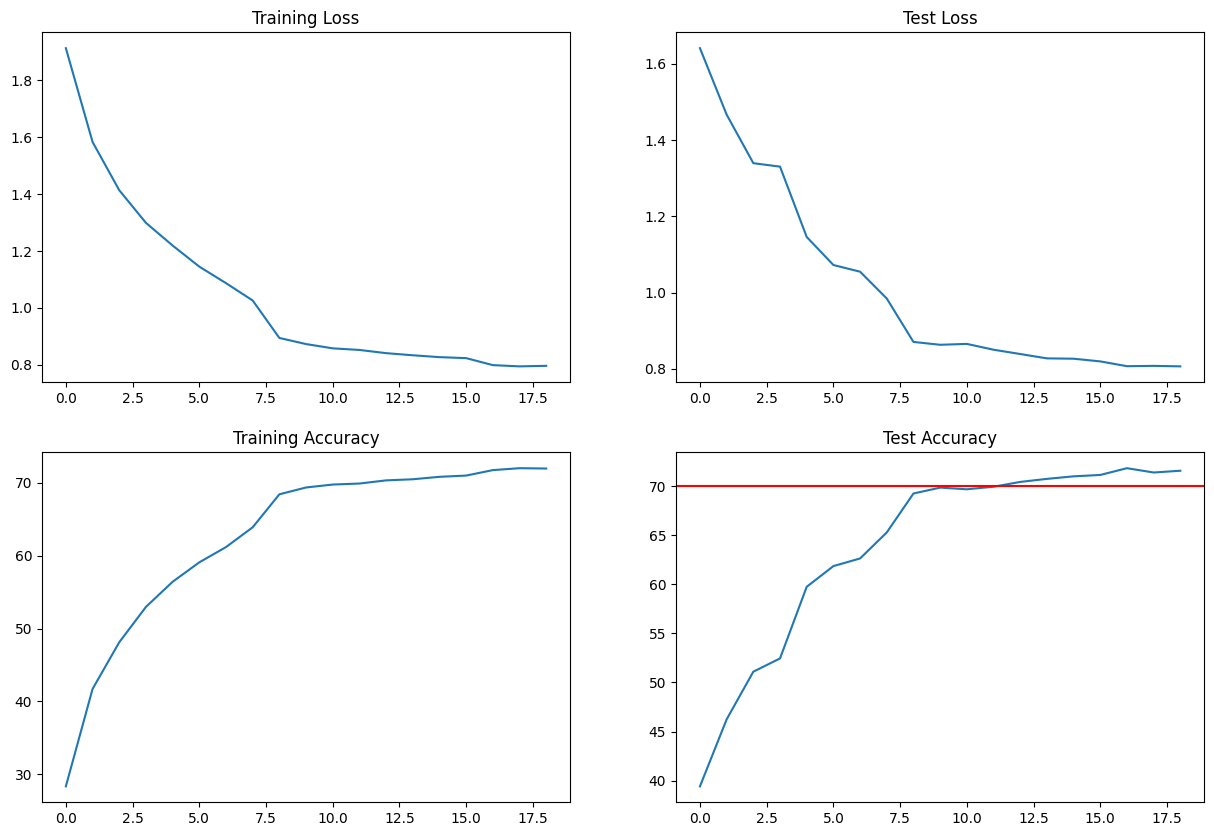

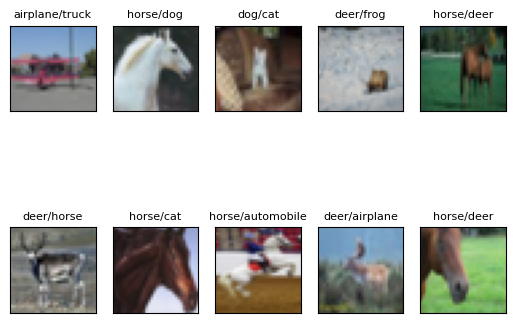

In [31]:
plot_statistics(train_losses_gn, train_acc_gn, test_losses_gn, test_acc_gn, target_test_acc)
incorrect_predictions_gn = get_incorrect_predictions(model_gn, test_loader, device)
show_incorrect_predictions(incorrect_predictions_gn, class_names, num_rows = 2, num_cols = 5)

In [37]:
def plot_statistics_groups(train_losses_list, train_acc_list, test_losses_list, test_acc_list, target_test_acc = 99):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(range(1,20),train_losses_list[0])
    axs[0,0].plot(range(1,20),train_losses_list[1])
    axs[0,0].plot(range(1,20),train_losses_list[2])
    axs[0, 0].set_title("Training Loss per epoch")
    #axs[0,0].set_xlabel("Epoch")
    axs[0,0].legend(["BatchNorm","LayerNorm","GroupNorm"],loc='best')
    axs[1, 0].plot(range(1,20),train_acc_list[0])
    axs[1,0].plot(range(1,20),train_acc_list[1])
    axs[1,0].plot(range(1,20),train_acc_list[2])
    #axs[1,0].set_xlabel("Epoch")
    axs[1, 0].set_title("Training Accuracy per epoch")
    axs[1,0].legend(["BatchNorm","LayerNorm","GroupNorm"],loc='best')
    axs[0, 1].plot(range(1,20),test_losses_list[0])
    axs[0,1].plot(range(1,20),test_losses_list[1])
    axs[0,1].plot(range(1,20),test_losses_list[2])
    #axs[0,1].set_xlabel("Epoch")
    axs[0, 1].set_title("Test Loss per epoch")
    axs[0,1].legend(["BatchNorm","LayerNorm","GroupNorm"],loc='best')
    axs[1, 1].plot(range(1,20),test_acc_list[0])
    axs[1,1].plot(range(1,20),test_acc_list[1])
    axs[1,1].plot(range(1,20),test_acc_list[2])
    #axs[1,1].set_xlabel("Epoch")
    axs[1, 1].axhline(target_test_acc, color='r')
    axs[1, 1].set_title("Test Accuracy per epoch")
    axs[1,1].legend(["BatchNorm","LayerNorm","GroupNorm"],loc='best')


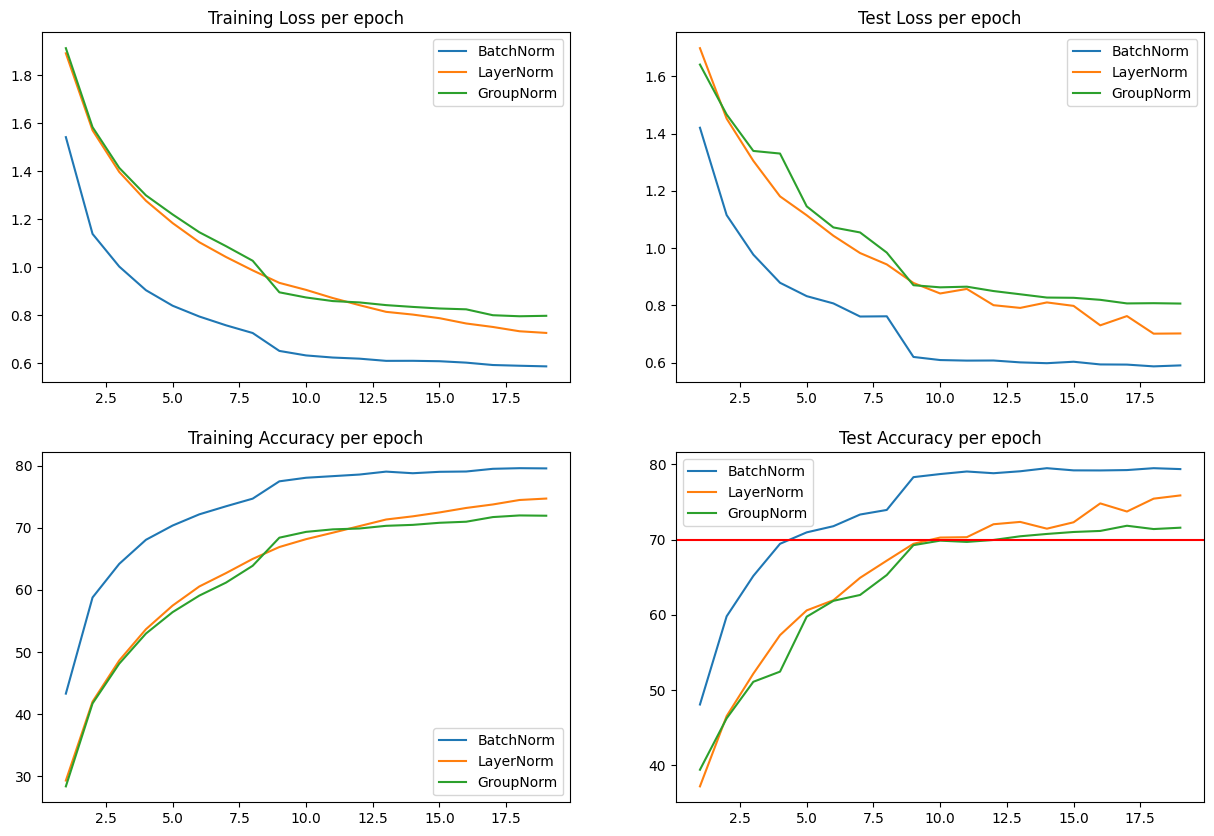

In [38]:
train_losses_list = [train_losses_bn, train_losses_ln, train_losses_gn]
train_acc_list = [train_acc_bn,train_acc_ln, train_acc_gn]
test_losses_list = [test_losses_bn, test_losses_ln, test_losses_gn]
test_acc_list = [test_acc_bn, test_acc_ln, test_acc_gn]
plot_statistics_groups(train_losses_list, train_acc_list, test_losses_list, test_acc_list, target_test_acc=70.0)